## Импорты & stuff

In [1]:
# !pip install -q -U pandas sklearn seaborn 

In [1]:
import random
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## EDA

In [4]:
data = pd.read_csv("data/sgemm_product.csv")

In [5]:
# 10 ordinal переменных и 4 бинарных + 4 целевых, которые можно объединить в одну путем усреднения
data.dtypes

MWG            int64
NWG            int64
KWG            int64
MDIMC          int64
NDIMC          int64
MDIMA          int64
NDIMB          int64
KWI            int64
VWM            int64
VWN            int64
STRM           int64
STRN           int64
SA             int64
SB             int64
Run1 (ms)    float64
Run2 (ms)    float64
Run3 (ms)    float64
Run4 (ms)    float64
dtype: object

In [6]:
# Все данные хорошие, никакой особой предобработки и исправлений не надо
for i in data.columns:
    print(f"Column '{i}' values: {data.loc[:, i].unique()}")

Column 'MWG' values: [ 16  32  64 128]
Column 'NWG' values: [ 16  32  64 128]
Column 'KWG' values: [16 32]
Column 'MDIMC' values: [ 8 16 32]
Column 'NDIMC' values: [ 8 16 32]
Column 'MDIMA' values: [ 8 16 32]
Column 'NDIMB' values: [ 8 16 32]
Column 'KWI' values: [2 8]
Column 'VWM' values: [1 2 4 8]
Column 'VWN' values: [1 2 4 8]
Column 'STRM' values: [0 1]
Column 'STRN' values: [0 1]
Column 'SA' values: [0 1]
Column 'SB' values: [0 1]
Column 'Run1 (ms)' values: [115.26  78.13  79.84 ...  26.27  26.4  144.61]
Column 'Run2 (ms)' values: [115.87  78.25  80.69 ... 256.13 155.21  17.79]
Column 'Run3 (ms)' values: [118.55  79.25  80.76 ... 122.68  17.31  17.78]
Column 'Run4 (ms)' values: [115.8   79.19  80.97 ... 157.27 263.33  27.12]


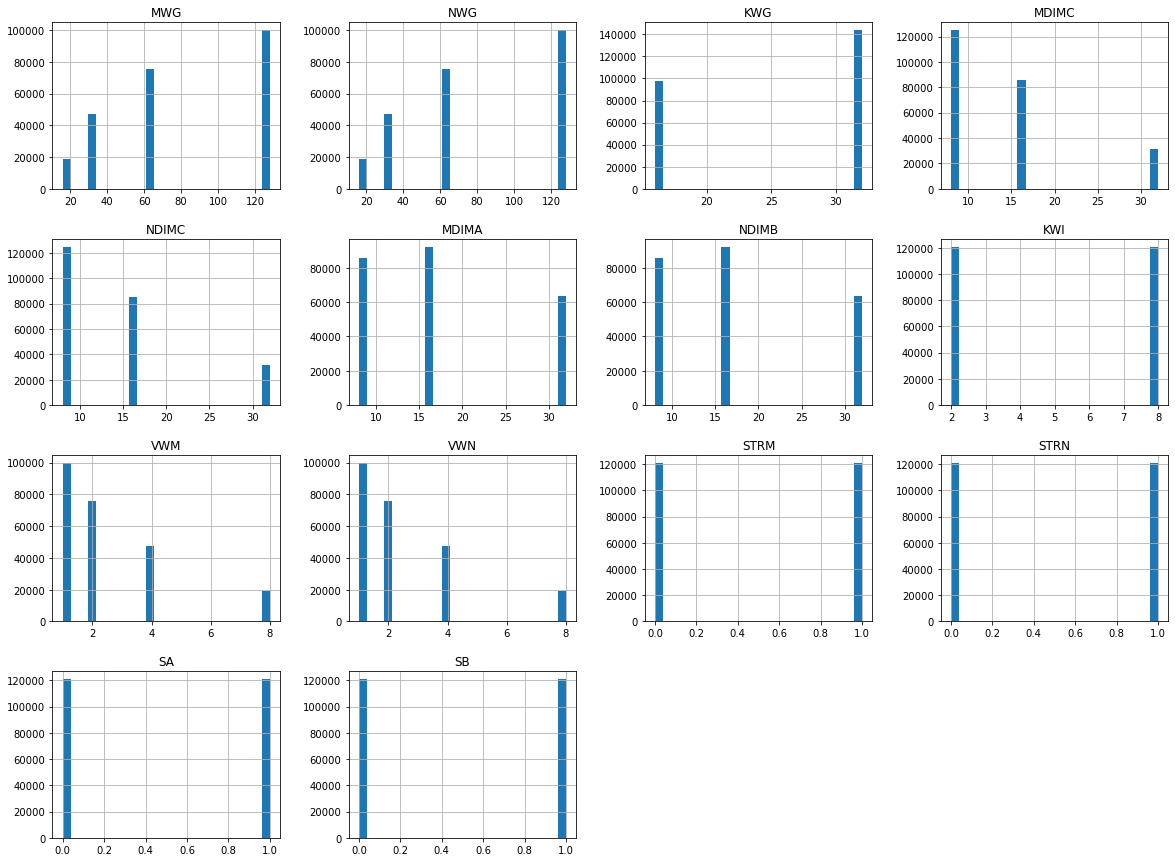

In [11]:
data.iloc[:, :-4].hist(figsize=(20, 15), bins=25)
plt.show()

In [12]:
# Усредним рантаймы, чтобы получить одну целевую переменную
# Здесь это вполне ок, у всех 4 переменных примерно одинаковые характеристики, совсем минимально отличаются друг от друга
# Подробнее дальше
data["avg_runtime"] = data.iloc[:, -4:].mean(axis=1)

In [13]:
# Все характеристики очень похожи
data.iloc[:, -5:].describe()

,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),avg_runtime
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,217.647852,217.579536,217.532756,217.527669,217.571953
std,369.012422,368.677309,368.655118,368.677413,368.750161
min,13.290000,13.250000,13.360000,13.370000,13.317500
25%,40.660000,40.710000,40.660000,40.640000,40.667500
50%,69.825000,69.930000,69.790000,69.820000,69.790000
75%,228.530000,228.310000,228.320000,228.320000,228.387500
max,3339.630000,3375.420000,3397.080000,3361.710000,3341.507500


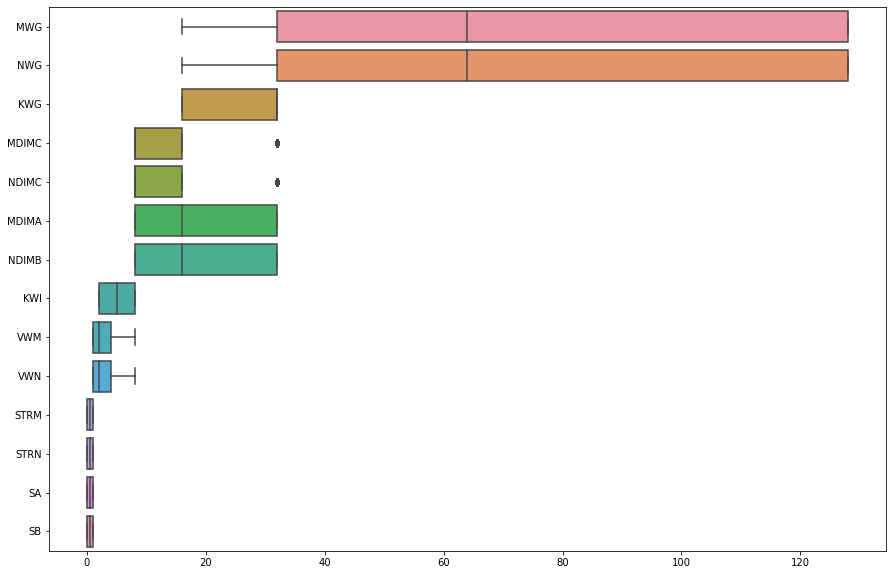

In [14]:
# Строим box-plot для каждой переменной
# Вообще, видим, что у переменных MDIMC и NDIMC есть выбросы, если смотреть чисто статистически
# Но если посмотреть на значения этих выбросах и прибегнуть к здравому смыслу и некоторому domain knowledge
# То видно, что это вполне себе корректные значения, так что не будет ничего удалять

plt.figure(figsize=(15, 10))
sns.boxplot(data=data.drop(columns=["Run1 (ms)", "Run2 (ms)", "Run3 (ms)", "Run4 (ms)", "avg_runtime"]), orient='h')
plt.show()

In [15]:
# Пропущенных значений даже нет, удивительно!))
data.isna().sum()

MWG            0
NWG            0
KWG            0
MDIMC          0
NDIMC          0
MDIMA          0
NDIMB          0
KWI            0
VWM            0
VWN            0
STRM           0
STRN           0
SA             0
SB             0
Run1 (ms)      0
Run2 (ms)      0
Run3 (ms)      0
Run4 (ms)      0
avg_runtime    0
dtype: int64

In [16]:
# Выведем список столбцов
data.iloc[:, :14].columns

Index(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB'],
      dtype='object')

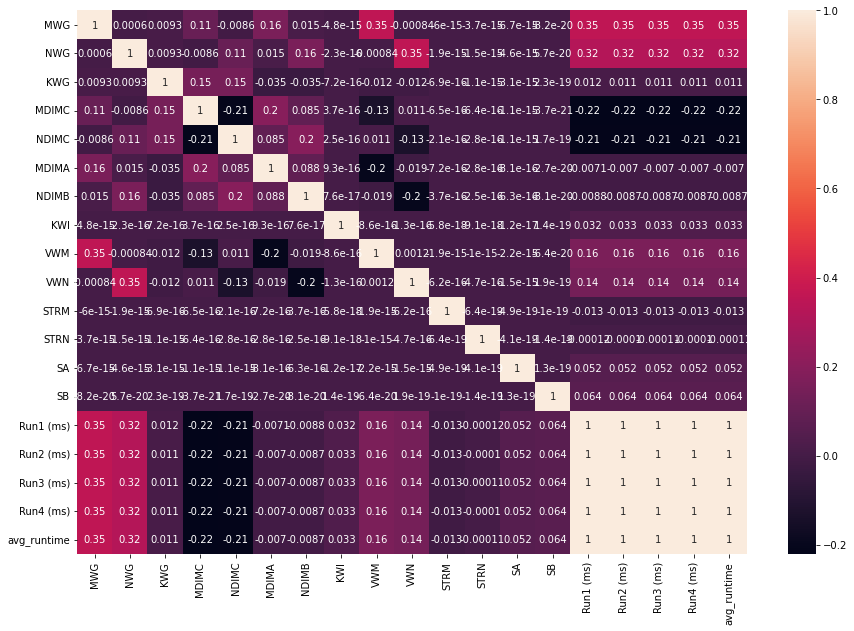

In [17]:
# Как мы видим, сильной корреляции (линейной!) между признаками нет, поэтому не будем ничего удалять
# Ну, за исключением рантаймов, там все понятно
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True)
plt.show()

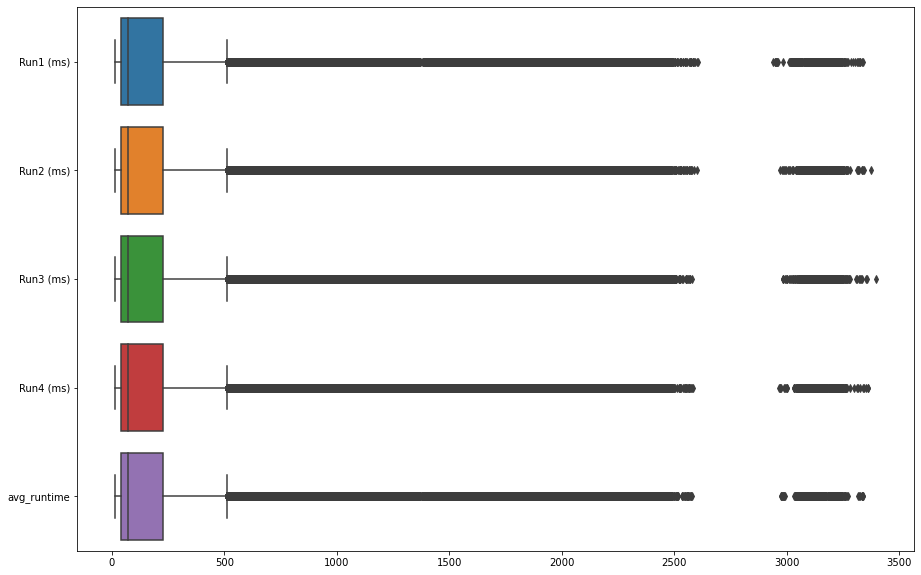

In [18]:
# Убедимся ещё раз, что усреднение было оправдано
plt.figure(figsize=(15, 10))
sns.boxplot(data=data[["Run1 (ms)", "Run2 (ms)", "Run3 (ms)", "Run4 (ms)", "avg_runtime"]], orient='h')
plt.show()

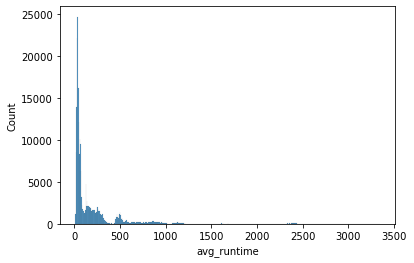

In [19]:
# Но вот незадача! Данные очень сильно скошены влево, так не годится
# Но, к счастью, даже в описании датасета рекомендуют привести целевую переменную к log-шкале, чтобы всё сгладить
# Мы сделаем так чуть позже, но пока давайте проанализируем, что есть
# Ну и если мы захотим анализировать выбросы уже на этом этапе, их будет, скажем так, достаточно много
# А вот удалять тонну наблюдений из-за ~потенциальных~ выбросов в ЦЕЛЕВОЙ перемнной не comme il faut

sns.histplot(data["avg_runtime"])
plt.show()

In [20]:
# Дропаем ненужные показатели
data = data.drop(["Run1 (ms)", "Run2 (ms)", "Run3 (ms)", "Run4 (ms)"], axis=1)

In [21]:
# Посмотрим все-таки на выбросы без log-шкалы
Q1 = data.loc[:, ["avg_runtime"]].quantile(0.25)
Q3 = data.loc[:, ["avg_runtime"]].quantile(0.75)
IQR = Q3 - Q1

iqr = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))

print(f'Q1\n{Q1}\n')
print(f'Q3\n{Q3}\n')
print(f'IQR\n{IQR}\n')

Q1
avg_runtime    40.6675
Name: 0.25, dtype: float64

Q3
avg_runtime    228.3875
Name: 0.75, dtype: float64

IQR
avg_runtime    187.72
dtype: float64



In [22]:
outlier_data = data[iqr[["avg_runtime"]].all(axis=1)]
rel_data = data[~iqr[["avg_runtime"]].all(axis=1)]

In [23]:
# Как-то совсем не очень, выбросов неприлично много так выходит
outlier_data["avg_runtime"].describe()

count    26767.000000
mean      1044.395308
std        595.430962
min        509.972500
25%        638.355000
50%        851.567500
75%       1139.076250
max       3341.507500
Name: avg_runtime, dtype: float64

In [24]:
# На остальных данных показатели достаточно сильно отличаются
rel_data["avg_runtime"].describe()

count    214833.000000
mean        114.554350
std         113.825481
min          13.317500
25%          39.095000
50%          61.790000
75%         157.892500
max         509.962500
Name: avg_runtime, dtype: float64

In [26]:
# Давайте еще попробуем отфильтровать выбросы, выходящие за пределы 3ей сигмы
# Их выходит меньше, уже лучше, но все еще многовато
# Понятно, конечно, что линрег сильно чувствителен к выбросам, но эти данные не кажутся реальными выбросами
# Посмотрим дальше
z = np.abs(stats.zscore(data[["avg_runtime"]]))
outliers = np.where(z > 3)
print(outliers[0].shape)

(5251,)


In [27]:
# Сравним характеристики независимых переменных у потенциальных выбросов и остальных значений
rel_data.iloc[:, :-1].describe().T

,count,mean,std,min,25%,50%,75%,max
MWG,214833.0,75.688037,41.968313,16.0,32.0,64.0,128.0,128.0
NWG,214833.0,75.761619,41.997377,16.0,32.0,64.0,128.0,128.0
KWG,214833.0,25.592567,7.839899,16.0,16.0,32.0,32.0,32.0
MDIMC,214833.0,14.475690,8.111065,8.0,8.0,16.0,16.0,32.0
NDIMC,214833.0,14.470700,8.111264,8.0,8.0,16.0,16.0,32.0
MDIMA,214833.0,17.390550,9.375134,8.0,8.0,16.0,32.0,32.0
NDIMB,214833.0,17.388762,9.374445,8.0,8.0,16.0,32.0,32.0
KWI,214833.0,5.005544,3.000002,2.0,2.0,8.0,8.0,8.0
VWM,214833.0,2.339538,1.858623,1.0,1.0,2.0,4.0,8.0
VWN,214833.0,2.345156,1.862122,1.0,1.0,2.0,4.0,8.0


In [28]:
# Видно, что признаки MWG, NWG, NDIMC, NDIMA достаточно сильно отличаются здесь от них же у нормальных данных
# Если бы особых отличий не было, а значение целевой переменной действительно сильно отличалось бы, то я бы поверил, что это просто выбросы
# Неполадки при снятии метрик или еще что-то, например
# Но не здесь
outlier_data.iloc[:, :-1].describe().T

,count,mean,std,min,25%,50%,75%,max
MWG,26767.0,118.357081,22.894988,64.0,128.0,128.0,128.0,128.0
NWG,26767.0,117.766504,23.549973,16.0,128.0,128.0,128.0,128.0
KWG,26767.0,24.875406,7.952108,16.0,16.0,32.0,32.0,32.0
MDIMC,26767.0,9.603467,3.229423,8.0,8.0,8.0,8.0,32.0
NDIMC,26767.0,9.643516,3.285071,8.0,8.0,8.0,8.0,32.0
MDIMA,26767.0,17.215228,9.502028,8.0,8.0,16.0,32.0,32.0
NDIMB,26767.0,17.229574,9.507730,8.0,8.0,16.0,32.0,32.0
KWI,26767.0,4.955505,2.999726,2.0,2.0,2.0,8.0,8.0
VWM,26767.0,3.324018,2.422102,1.0,1.0,2.0,4.0,8.0
VWN,26767.0,3.278926,2.418387,1.0,1.0,2.0,4.0,8.0


In [29]:
# И все же приведем к лог-шкале
data["avg_runtime"] = data["avg_runtime"].apply(np.log)

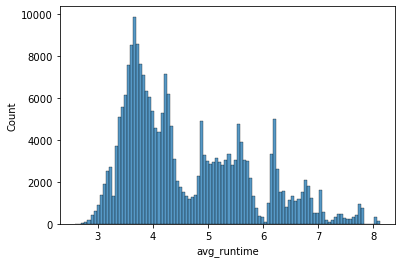

In [30]:
# И оценим ее
# Распределение выглядит значительно адекватнее прошлого
sns.histplot(data["avg_runtime"])
plt.show()

In [31]:
# Снова считаем IQR и смотрим на количество выбросов
Q1 = data.loc[:, ["avg_runtime"]].quantile(0.25)
Q3 = data.loc[:, ["avg_runtime"]].quantile(0.75)
IQR = Q3 - Q1

iqr = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))

print(f'Q1\n{Q1}\n')
print(f'Q3\n{Q3}\n')
print(f'IQR\n{IQR}\n')

Q1
avg_runtime    3.705429
Name: 0.25, dtype: float64

Q3
avg_runtime    5.431044
Name: 0.75, dtype: float64

IQR
avg_runtime    1.725614
dtype: float64



In [32]:
outlier_data = data[iqr[["avg_runtime"]].all(axis=1)]
rel_data = data[~iqr[["avg_runtime"]].all(axis=1)]

In [33]:
outlier_data["avg_runtime"].describe()

count    471.000000
mean       8.053503
std        0.018557
min        8.019606
25%        8.041629
50%        8.049692
75%        8.063404
max        8.114177
Name: avg_runtime, dtype: float64

In [34]:
rel_data["avg_runtime"].describe()

count    241129.000000
mean          4.616367
std           1.119391
min           2.589079
25%           3.704814
50%           4.243160
75%           5.425005
max           8.019197
Name: avg_runtime, dtype: float64

In [35]:
# Считаем z-score и смотрим на количество выбросов
# Здесь их уже примерно поровну, так что это выглядит уже значительно адекватнее
# Ну и удалить такие 500 вхождений из датасета на сотни тысяч наблюдений уже вполне ок
z = np.abs(stats.zscore(data[["avg_runtime"]]))
outliers = np.where(z > 3)
print(outliers[1].shape)

(475,)


In [36]:
# Так и сделаем
data = data.drop(outliers[0]).reset_index(drop=True)

In [37]:
scaler = StandardScaler()

In [38]:
# Отскейлим все (числовые) признаки
X = pd.DataFrame(
    data=scaler.fit_transform(data.drop("avg_runtime", axis=1)),
    columns=data.drop("avg_runtime", axis=1).columns
    )

y = data["avg_runtime"]

### Сплит датасета и служебные функции

In [39]:
def metrify(model, y_true, y_pred):
    print("========")
    print(f"MSE: {np.round(mse(y_true, y_pred), 4)}")
    print(f"RMSE: {np.round((mse(y_true, y_pred, squared=False)), 4)}")
    print(f"MAE: {np.round(mae(y_true, y_pred), 4)}")
    print(f"R**2 score: {np.round(r2(y_true, y_pred), 4)}")
    print("========")

In [40]:
def make_polyreg(degree=2, model=LinearRegression, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), model(**kwargs))

    
def fit_polyreg(model_type=LinearRegression, degree=1):
    polyreg = make_polyreg(degree=degree, model=model_type)
    model = polyreg.fit(X_train, y_train)
    metrify(model, y_val, model.predict(X_val))
    return model

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

## Обучаем линейной и полиномиальной регрессии

In [42]:
# Обучаем дефолтный линрег и смотрим на коэффициенты признаков

linreg = LinearRegression().fit(X_train, y_train)
metrify(linreg, y_val, linreg.predict(X_val))
print("LinearRegression\n")
pd.DataFrame({"columns": X_train.columns, "coefs": linreg.coef_}).sort_values(by="coefs", ascending=False)

MSE: 0.5564
RMSE: 0.7459
MAE: 0.5983
R**2 score: 0.5603
LinearRegression



,columns,coefs
0,MWG,0.562402
1,NWG,0.443721
2,KWG,0.093083
5,MDIMA,-0.000133
6,NDIMB,-0.000664
11,STRN,-0.008963
7,KWI,-0.015212
8,VWM,-0.016829
13,SB,-0.027260
9,VWN,-0.045847


In [43]:
# При использовании полиномиальной регрессии 2ой степени все метрики сильно растут

polyreg_2 = fit_polyreg(degree=2)

MSE: 0.2385
RMSE: 0.4884
MAE: 0.3925
R**2 score: 0.8115


In [44]:
# При использовании полиномиальной регрессии 3ой степени все метрики еще сильнее растут

polyreg_3 = fit_polyreg(degree=3)

MSE: 0.1512
RMSE: 0.3889
MAE: 0.3135
R**2 score: 0.8805


In [45]:
# При использовании Ridge со стандартной alpha=1 коэффициенты признаков и качество не изменяются

ridge = Ridge().fit(X_train, y_train)
metrify(ridge, y_val, ridge.predict(X_val))
print("Ridge", f"alpha=1\n")
pd.DataFrame({"columns": X_train.columns, "coefs": ridge.coef_}).sort_values(by="coefs", ascending=False)

MSE: 0.5564
RMSE: 0.7459
MAE: 0.5983
R**2 score: 0.5603
Ridge alpha=1



,columns,coefs
0,MWG,0.562398
1,NWG,0.443717
2,KWG,0.093082
5,MDIMA,-0.000133
6,NDIMB,-0.000664
11,STRN,-0.008963
7,KWI,-0.015212
8,VWM,-0.016827
13,SB,-0.027260
9,VWN,-0.045845


In [46]:
# При использовании Lasso со стандартной alpha=1 все коэффициенты признаков зануляются, а качество при этом падает очень сильно падает

lasso = Lasso().fit(X_train, y_train)
metrify(lasso, y_val, lasso.predict(X_val))
print("Lasso", f"alpha=1\n")
pd.DataFrame({"columns": X_train.columns, "coefs": lasso.coef_}).sort_values(by="coefs", ascending=False)

MSE: 1.2656
RMSE: 1.125
MAE: 0.9564
R**2 score: -0.0001
Lasso alpha=1



,columns,coefs
0,MWG,0.0
1,NWG,0.0
2,KWG,-0.0
3,MDIMC,-0.0
4,NDIMC,-0.0
5,MDIMA,-0.0
6,NDIMB,-0.0
7,KWI,-0.0
8,VWM,0.0
9,VWN,0.0


In [47]:
# При использовании Lasso с alpha=0.001 коэффициенты признаков [MDIMA, NDIMB] зануляются, а качество при этом не падает

lasso = Lasso(alpha=0.001).fit(X_train, y_train)
metrify(lasso, y_val, lasso.predict(X_val))
print("Lasso", f"alpha=0.001\n")

pd.DataFrame({"columns": X_train.columns, "coefs": lasso.coef_}).sort_values(by="coefs", ascending=False)

MSE: 0.5565
RMSE: 0.746
MAE: 0.5986
R**2 score: 0.5602
Lasso alpha=0.001



,columns,coefs
0,MWG,0.560503
1,NWG,0.441704
2,KWG,0.091608
5,MDIMA,-0.000000
6,NDIMB,-0.000000
11,STRN,-0.007964
7,KWI,-0.014215
8,VWM,-0.014900
13,SB,-0.026271
9,VWN,-0.043775


In [48]:
# При использовании ElasticNet с подобранной alpha=0.01 коэффициенты признаков [MDIMA, NDIMB] зануляются, а качество при этом падает всего на тысячные

elastic_net = ElasticNet(alpha=0.01).fit(X_train, y_train)
metrify(elastic_net, y_val, elastic_net.predict(X_val))
pd.DataFrame({"columns": X_train.columns, "coefs": elastic_net.coef_}).sort_values(by="coefs", ascending=False)

MSE: 0.5574
RMSE: 0.7466
MAE: 0.6005
R**2 score: 0.5595


,columns,coefs
0,MWG,0.549316
1,NWG,0.431162
2,KWG,0.084031
5,MDIMA,0.000000
6,NDIMB,-0.000000
11,STRN,-0.003947
8,VWM,-0.005576
7,KWI,-0.010199
13,SB,-0.022237
9,VWN,-0.034505


#### Подбор параметров

In [49]:
# Из предыдущих экспериментов мы можем видеть, что лучше всего работают:
# - линейная регрессия и Lasso с умеренной регуляризацией (если не учитывать полиномиальные признаки)
# - полиномиальная регрессия (очень большой прирост по всем метрикам, взяв за основу линейную регрессию)

# Так как Lasso справился (по метрикам) не хуже линейной регрессии без регуляризации, но еще и занулил два признаки, сделав модель чуть проще
# Попробуем использовать и его с полиномиальными признаками и разными степенями регуляризации, чтобы посмотреть, что из этого выйдет

In [44]:
%%time
estimators = [make_polyreg(model=LinearRegression), make_polyreg(model=Lasso)]
best_estimators = []


params = [
    {"polynomialfeatures__degree": (2, 3)},
    {"polynomialfeatures__degree": (2, 3), "lasso__alpha": [0.001, 0.01, 0.1, 0.5]}
]

scores = ["neg_mean_squared_error", "neg_root_mean_squared_error", "neg_median_absolute_error", "r2"]

for i, estimator in enumerate(estimators):
    grid = GridSearchCV(estimator, param_grid=params[i], verbose=1, refit="r2", cv=3).fit(X_train, y_train)
    best_estimators.append(grid.best_estimator_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 1h 17min 27s, sys: 37min, total: 1h 54min 28s
Wall time: 15min 21s


In [52]:
# Наконец, на основе всех проведенных экспериментов можно сделать следующие выводы:
# 1. Признаки MDIMA и NDIMB являются далеко не самыми важными, потому что зануляются даже при умеренной регуляризации
# 2. Обычной линейной регрессии недостаточно, чтобы моделировать и апроксимировать зависимости в этих данных
# 3. Полиномиальная регрессия 2 и 3 степеней (остальные не тестировал) справляется с этим значительно лучше
# 4. Таким образом, можно говорить о том, что в данных достаточно много нелинейных зависимостей
# 5. Регрессии с полиномиальными признаками 3 степени работают лучше всего (не особо удивительно)
# 6. Без регуляризации работает даже чуточку лучше
# 6. Ну и, конечно, можно говорить о том, что кросс-валидировать полиномиальную регрессию долго, нейронки хоть в A100 можно обернуть, чтобы раз-раз и готово :)

for i, estim in enumerate(best_estimators):
    print(estimators[i])
    metrify(estim, y_test, estim.predict(X_test))
    print()

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])
MSE: 0.1541
RMSE: 0.3926
MAE: 0.3144
R**2 score: 0.8763

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso())])
MSE: 0.1554
RMSE: 0.3942
MAE: 0.3158
R**2 score: 0.8753



In [57]:
best_estimators[0][1].get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [58]:
best_estimators[1][1].get_params()

{'alpha': 0.001,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}